# KNN vs Modified KNN (MKNN) Classification on Iris Dataset

A comprehensive comparison between **Standard K-Nearest Neighbors (KNN)** and a **Modified KNN (MKNN)** that uses:
- **Validity score** of training samples (based on how many of their k-nearest neighbors belong to the same class)
- **Weighted voting** using validity × inverse distance

We will use the classic **Iris dataset** and evaluate both models using cross-validation, accuracy comparison, confusion matrices, and classification reports.

---

## 1. Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load and Explore the Iris Dataset

In [3]:
# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Create DataFrame for better visualization
df = pd.DataFrame(X, columns=iris.feature_names)
df['target'] = y
df['target_name'] = df['target'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nClass Distribution:")
print(df['target_name'].value_counts())

Dataset Shape: (150, 6)

First 5 rows:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target target_name  
0       0      setosa  
1       0      setosa  
2       0      setosa  
3       0      setosa  
4       0      setosa  

Class Distribution:
target_name
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64


## 3. Data Visualization (Scatter Plots)

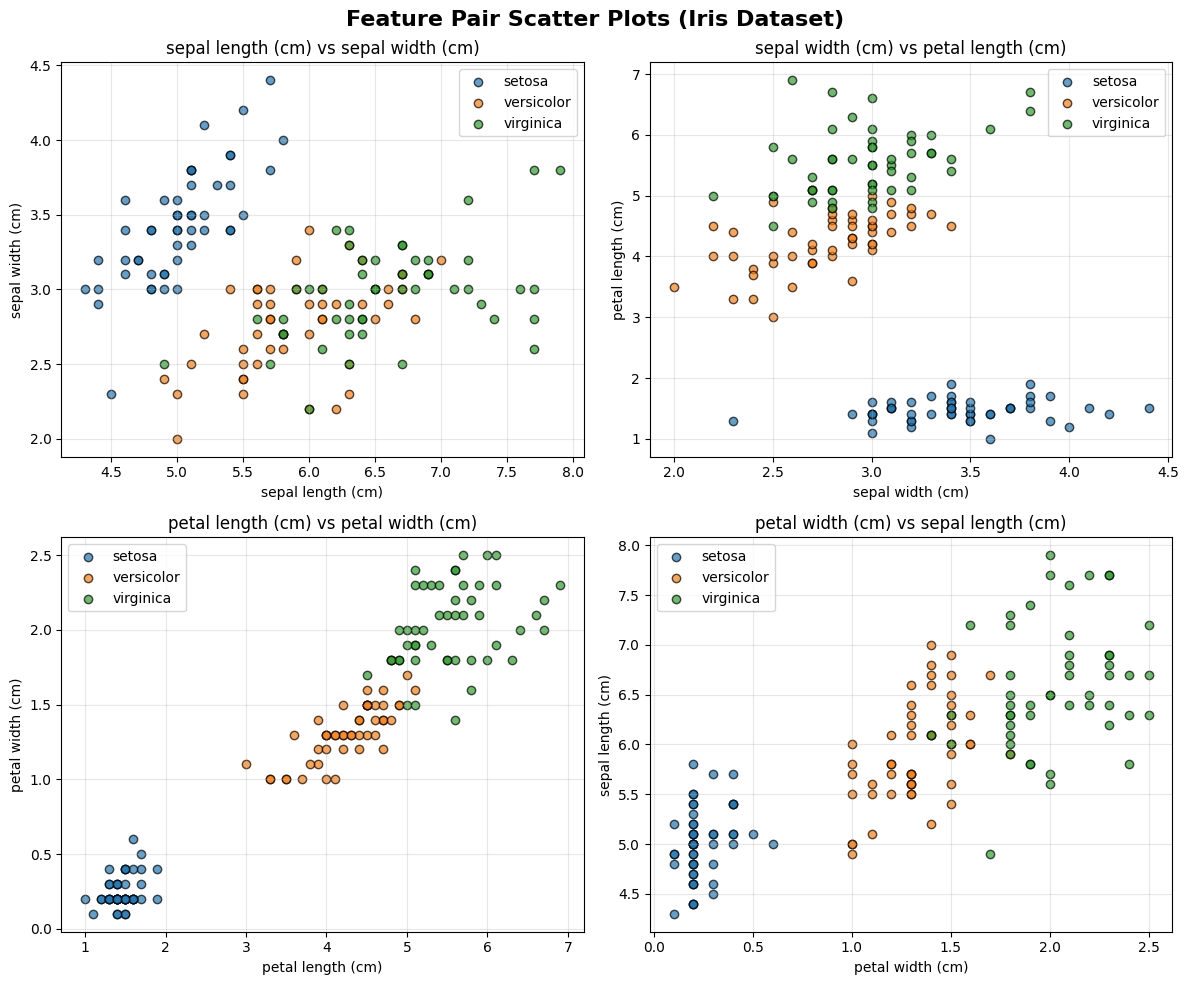

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for idx, feature in enumerate(iris.feature_names[:4]):
    ax = axes[idx//2, idx%2]
    for target in [0, 1, 2]:
        mask = y == target
        ax.scatter(X[mask, idx], X[mask, (idx+1)%4],
                  label=iris.target_names[target], alpha=0.7, edgecolors='k')
    ax.set_xlabel(feature)
    ax.set_ylabel(iris.feature_names[(idx+1)%4])
    ax.legend()
    ax.set_title(f'{feature} vs {iris.feature_names[(idx+1)%4]}')
    ax.grid(True, alpha=0.3)

plt.suptitle("Feature Pair Scatter Plots (Iris Dataset)", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Standard KNN Implementation (From Scratch)

In [5]:
class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def predict(self, X_test):
        predictions = []
        for test_point in X_test:
            distances = []
            for idx, train_point in enumerate(self.X_train):
                dist = self.euclidean_distance(test_point, train_point)
                distances.append((dist, self.y_train[idx]))

            distances.sort(key=lambda x: x[0])
            k_nearest = distances[:self.k]
            k_nearest_labels = [label for _, label in k_nearest]
            most_common = Counter(k_nearest_labels).most_common(1)
            predictions.append(most_common[0][0])

        return np.array(predictions)

print("Standard KNN class implemented successfully!")

Standard KNN class implemented successfully!


## 5. Modified KNN (MKNN) with Validity + Weighted Voting

In [6]:
class MKNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.n_train = len(X_train)
        self.validity = self._calculate_validity()

    def euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def _calculate_validity(self):
        validity = np.zeros(self.n_train)

        for i in range(self.n_train):
            distances = []
            for j in range(self.n_train):
                if i != j:
                    dist = self.euclidean_distance(self.X_train[i], self.X_train[j])
                    distances.append((dist, j))

            distances.sort(key=lambda x: x[0])
            k_nearest_indices = [idx for _, idx in distances[:self.k]]

            for neighbor_idx in k_nearest_indices:
                if self.y_train[i] == self.y_train[neighbor_idx]:
                    validity[i] += 1

        return validity

    def predict(self, X_test):
        predictions = []

        for test_point in X_test:
            distances = []
            for idx, train_point in enumerate(self.X_train):
                dist = self.euclidean_distance(test_point, train_point)
                distances.append((dist, idx))

            distances.sort(key=lambda x: x[0])
            k_nearest = distances[:self.k]

            class_weights = {}
            for dist, idx in k_nearest:
                label = self.y_train[idx]
                weight = self.validity[idx] * (1 / (dist + 1e-5))  # Avoid division by zero
                class_weights[label] = class_weights.get(label, 0) + weight

            predicted_class = max(class_weights.items(), key=lambda x: x[1])[0]
            predictions.append(predicted_class)

        return np.array(predictions)

print("MKNN class implemented successfully!")

MKNN class implemented successfully!


## 6. Data Preprocessing: Train/Test Split + Standardization

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 105
Testing samples: 45


## 7. K-Fold Cross Validation to Find Best K

In [8]:
def perform_cross_validation(X, y, k_values=[1,3,5,7,9], n_splits=5):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    results_knn = {k: [] for k in k_values}
    results_mknn = {k: [] for k in k_values}

    for train_idx, val_idx in kfold.split(X):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        scaler = StandardScaler()
        X_train_fold = scaler.fit_transform(X_train_fold)
        X_val_fold = scaler.transform(X_val_fold)

        for k in k_values:
            # KNN
            knn = KNN(k=k)
            knn.fit(X_train_fold, y_train_fold)
            acc_knn = accuracy_score(y_val_fold, knn.predict(X_val_fold))
            results_knn[k].append(acc_knn * 100)

            # MKNN
            mknn = MKNN(k=k)
            mknn.fit(X_train_fold, y_train_fold)
            acc_mknn = accuracy_score(y_val_fold, mknn.predict(X_val_fold))
            results_mknn[k].append(acc_mknn * 100)

    return results_knn, results_mknn

print("Running 5-Fold Cross Validation...")
cv_knn, cv_mknn = perform_cross_validation(X, y)

print("\n=== Cross Validation Results ===")
print("KNN Mean Accuracies:")
for k in cv_knn:
    print(f"K={k}: {np.mean(cv_knn[k]):.2f}% ± {np.std(cv_knn[k]):.2f}%")

print("\nMKNN Mean Accuracies:")
for k in cv_mknn:
    print(f"K={k}: {np.mean(cv_mknn[k]):.2f}% ± {np.std(cv_mknn[k]):.2f}%")

Running 5-Fold Cross Validation...

=== Cross Validation Results ===
KNN Mean Accuracies:
K=1: 95.33% ± 3.40%
K=3: 96.00% ± 3.27%
K=5: 96.00% ± 3.27%
K=7: 94.67% ± 4.00%
K=9: 94.67% ± 3.40%

MKNN Mean Accuracies:
K=1: 95.33% ± 3.40%
K=3: 96.00% ± 3.27%
K=5: 96.00% ± 3.27%
K=7: 96.00% ± 3.89%
K=9: 96.00% ± 3.89%


## 8. Test Both Models Across K = 1 to 10

In [9]:
k_values = range(1, 11)
knn_accuracies = []
mknn_accuracies = []

for k in k_values:
    knn = KNN(k=k)
    knn.fit(X_train_scaled, y_train)
    y_pred_knn = knn.predict(X_test_scaled)
    knn_accuracies.append(accuracy_score(y_test, y_pred_knn) * 100)

    mknn = MKNN(k=k)
    mknn.fit(X_train_scaled, y_train)
    y_pred_mknn = mknn.predict(X_test_scaled)
    mknn_accuracies.append(accuracy_score(y_test, y_pred_mknn) * 100)

comparison_df = pd.DataFrame({'K': list(k_values), 'KNN (%)': knn_accuracies, 'MKNN (%)': mknn_accuracies})
print(comparison_df.round(2))

    K  KNN (%)  MKNN (%)
0   1    93.33     93.33
1   2    93.33     88.89
2   3    91.11     91.11
3   4    93.33     93.33
4   5    91.11     91.11
5   6    91.11     91.11
6   7    93.33     93.33
7   8    95.56     95.56
8   9    95.56     95.56
9  10    95.56     93.33


## 9. Visualization: Accuracy vs K

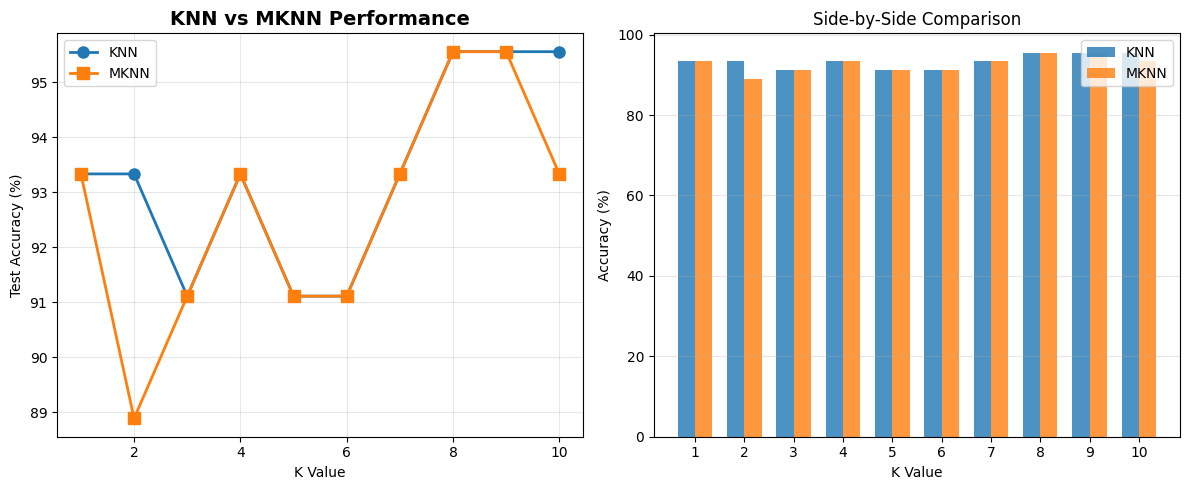

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, knn_accuracies, 'o-', label='KNN', linewidth=2, markersize=8)
plt.plot(k_values, mknn_accuracies, 's-', label='MKNN', linewidth=2, markersize=8)
plt.title('KNN vs MKNN Performance', fontsize=14, fontweight='bold')
plt.xlabel('K Value')
plt.ylabel('Test Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
x = np.arange(len(k_values))
width = 0.35
plt.bar(x - width/2, knn_accuracies, width, label='KNN', alpha=0.8)
plt.bar(x + width/2, mknn_accuracies, width, label='MKNN', alpha=0.8)
plt.xlabel('K Value')
plt.ylabel('Accuracy (%)')
plt.title('Side-by-Side Comparison')
plt.xticks(x, k_values)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 10. Final Evaluation with Best K

In [11]:
best_k_knn = list(k_values)[np.argmax(knn_accuracies)]
best_k_mknn = list(k_values)[np.argmax(mknn_accuracies)]

print(f"Best K for KNN: {best_k_knn} → {max(knn_accuracies):.2f}%")
print(f"Best K for MKNN: {best_k_mknn} → {max(mknn_accuracies):.2f}%")

# Final models
knn_final = KNN(k=best_k_knn)
knn_final.fit(X_train_scaled, y_train)
y_pred_knn = knn_final.predict(X_test_scaled)

mknn_final = MKNN(k=best_k_mknn)
mknn_final.fit(X_train_scaled, y_train)
y_pred_mknn = mknn_final.predict(X_test_scaled)

Best K for KNN: 8 → 95.56%
Best K for MKNN: 8 → 95.56%


## 11. Confusion Matrices

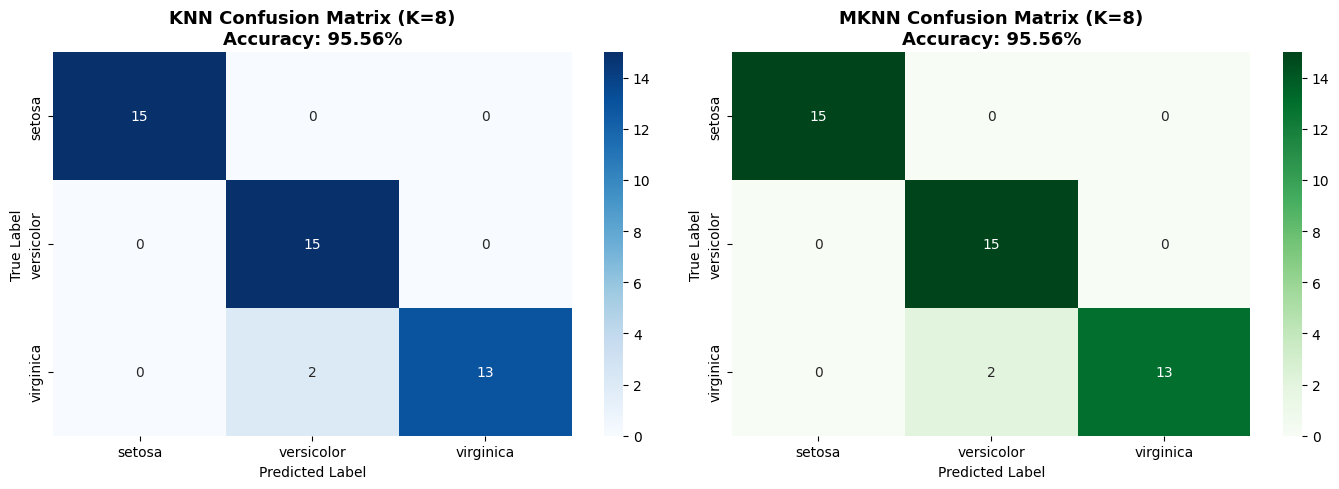

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# KNN Confusion Matrix
sns.heatmap(confusion_matrix  (y_test, y_pred_knn),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=iris.target_names,
            yticklabels=iris.target_names,
            ax=axes[0])
axes[0].set_title(f'KNN Confusion Matrix (K={best_k_knn})\nAccuracy: {max(knn_accuracies):.2f}%',
                  fontsize=13, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# MKNN Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_mknn),
            annot=True, fmt='d', cmap='Greens',
            xticklabels=iris.target_names,
            yticklabels=iris.target_names,
            ax=axes[1])
axes[1].set_title(f'MKNN Confusion Matrix (K={best_k_mknn})\nAccuracy: {max(mknn_accuracies):.2f}%',
                  fontsize=13, fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

## 12. Classification Reports

In [20]:
print("KNN Classification Report".center(50, "="))
print(classification_report(y_test, y_pred_knn, target_names=iris.target_names))

print("MKNN Classification Report".center(50, "="))
print(classification_report(y_test, y_pred_mknn, target_names=iris.target_names))

============KNN Classification Report=============
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.88      1.00      0.94        15
   virginica       1.00      0.87      0.93        15

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45

============MKNN Classification Report============
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.88      1.00      0.94        15
   virginica       1.00      0.87      0.93        15

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



## 13. Final Summary

In [22]:
print("="*60)
print("FINAL SUMMARY".center(60))
print("="*60)
print(f"Dataset: Iris (150 samples, 4 features, 3 classes)")
print(f"Train/Test Split: 70/30 | Random State: 42")
print(f"Best KNN (K={best_k_knn}): {max(knn_accuracies):.2f}%")
print(f"Best MKNN (K={best_k_mknn}): {max(mknn_accuracies):.2f}%")
print(f"Average KNN Accuracy: {np.mean(knn_accuracies):.2f}%")
print(f"Average MKNN Accuracy: {np.mean(mknn_accuracies):.2f}%")
print(f"Improvement with MKNN: {np.mean(mknn_accuracies) - np.mean(knn_accuracies):.2f}%")

                       FINAL SUMMARY                        
Dataset: Iris (150 samples, 4 features, 3 classes)
Train/Test Split: 70/30 | Random State: 42
Best KNN (K=8): 95.56%
Best MKNN (K=8): 95.56%
Average KNN Accuracy: 93.33%
Average MKNN Accuracy: 92.67%
Improvement with MKNN: -0.67%
